In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [40]:
# blue
color_0 = '#1f77b4'
color_0_light = '#8fbbd9'

# orange
color_1 = '#ff7f0e'
color_1_light = '#ffbf86'

colors = [color_0, color_1]
colors_light = [color_0_light,color_1_light]

# other constants
lower_percentile = 0.159
upper_percentile = 0.841

plt.rcParams.update({'font.size': 24,
                     'xtick.labelsize': 20,
                     'ytick.labelsize': 20,
                     'axes.titlesize': 28,
                     'axes.labelsize': 28,
                     'mathtext.fontset': 'stix',
                     'font.family': 'STIXGeneral'})

In [41]:
margin=-0.1
df = pd.read_csv(f'experiments/M_{margin}_data.csv')
df = df[df['M'] == 256]
sep = 'separable' if margin > 0 else 'overlap'
shots = [4,8,16,32,64,128,256,512,1024,2048,4096, 8192] #list(set(df['R'])) #
shots.sort()

100
(12, 3)
[[2.90888822 4.63263412 0.76859642 1.59192511 1.28199623 1.14247518
  1.46932417 1.36625373 0.49411094 0.22677367 0.35817967 0.27523135]
 [2.91928682 4.54078774 0.78023316 1.6405994  1.2462987  1.11308362
  1.42242959 1.35553388 0.49407091 0.22862677 0.35000782 0.27433028]]
[-2.00560513 10.35071481]
100
(12, 3)
[[274.63710527 147.40419932 513.58052961 151.86928177  88.48302267
   92.35031947 125.94279707 103.05432376  58.64016723  28.10358344
   23.41341511  13.65252572]
 [285.08459782 145.53494913 517.89709352 149.671301    86.14702213
   93.6649103  121.35587951  99.58569747  58.42103382  28.50691777
   23.48718763  13.10108384]]
[-2.36241268 22.63798319]


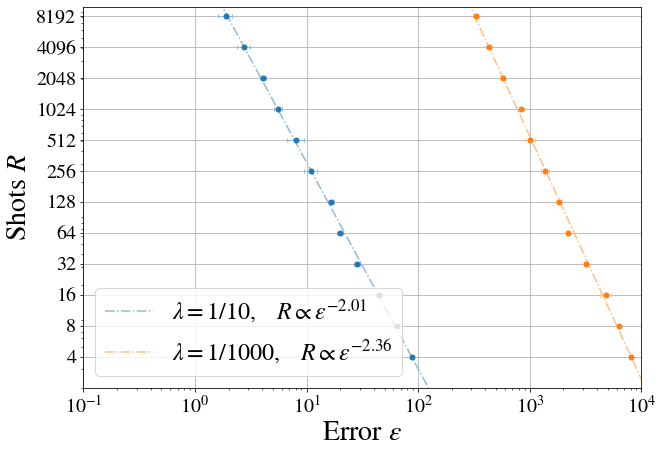

In [42]:
plt.figure(figsize=(10,7))
for i, C in enumerate([10.,1000.]):
    filter = df['C'] == C
    print(np.sum(filter))
    epsilons = np.array([df['epsilon'][(df['R'] == int(R)) & filter ][:3] for R in shots])
    print(epsilons.shape)
    means = np.mean(epsilons,axis=1)
    upper = np.quantile(epsilons, upper_percentile, axis=1)
    lower = np.quantile(epsilons,lower_percentile,axis=1)
    errors = np.array([means - lower, upper - means])
    print(errors)
    plt.errorbar(means,shots,xerr=errors,marker='.',ecolor=colors_light[i],elinewidth=1.,ls='',capsize=2,
        color=colors[i], ms=10)
    #plt.scatter(means,shots,c=colors[i])
    #plt.errorbar(means,shots,xerr=stds,fmt='.')
    plt.xscale('log')
    plt.yscale('log')
    p = np.polyfit(np.log(means),np.log(shots),1)
    print(p)
    efine = np.geomspace(0.0001,1e4,1000)
    plt.plot(efine,np.exp(p[1])*efine**(p[0]),linestyle='-.',label=r'$\lambda = 1/{{%s}},\quad R\propto\varepsilon^{{%.2f}}$'%(int(C),p[0]),color=colors_light[i])

plt.yticks(shots,shots)
plt.xlim(1e-1,1e4)
plt.ylim(2,1e4)
plt.xlabel(r'Error $\varepsilon$')
plt.ylabel(r'Shots $R$')
plt.grid()
plt.legend(loc='lower left')
plt.savefig(f'plots/dual_exponent_{sep}.png',dpi=300,bbox_inches='tight')